In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from pathlib import Path

In [ ]:
dataset_path = Path(r'/content/gdrive/MyDrive/setyo/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))

# create labels from the folder name
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
import pandas as pd

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/gdrive/MyDrive/setyo/Fish_Dataset/Fis...,Striped Red Mullet GT
1,/content/gdrive/MyDrive/setyo/Fish_Dataset/Fis...,Striped Red Mullet GT
2,/content/gdrive/MyDrive/setyo/Fish_Dataset/Fis...,Striped Red Mullet GT
3,/content/gdrive/MyDrive/setyo/Fish_Dataset/Fis...,Striped Red Mullet GT
4,/content/gdrive/MyDrive/setyo/Fish_Dataset/Fis...,Striped Red Mullet GT


In [ ]:
import matplotlib.pyplot as plt

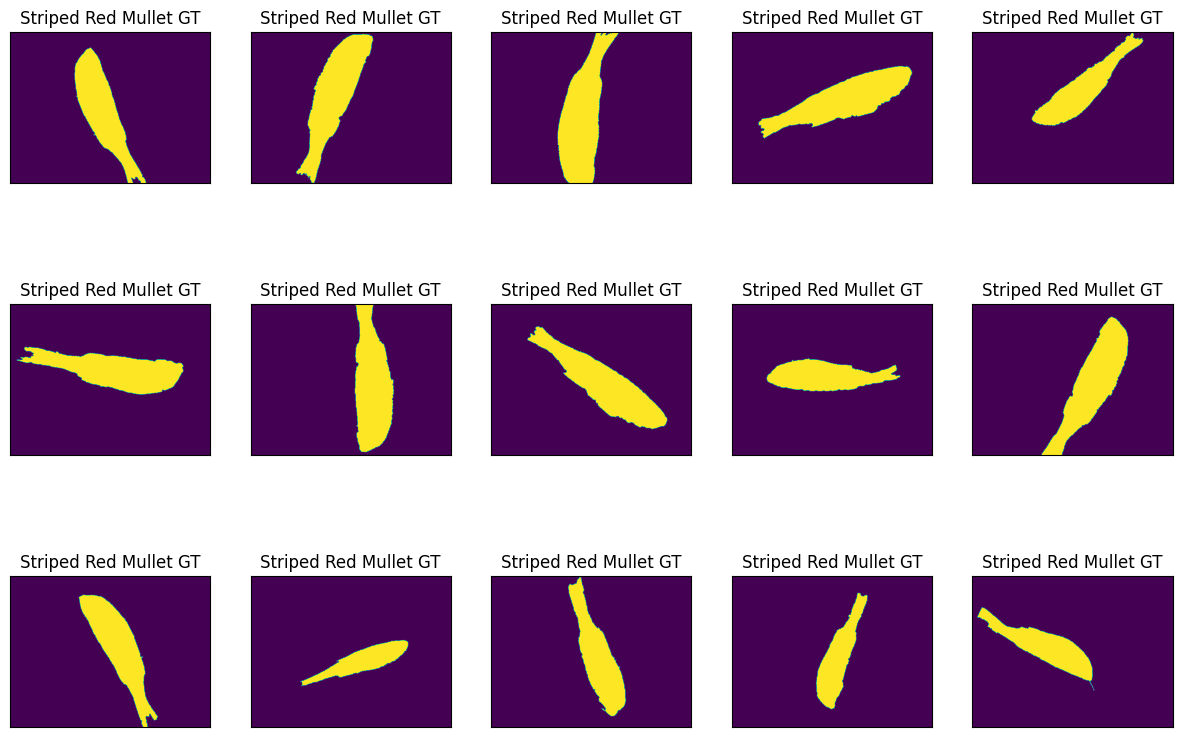

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])

plt.show()

In [ ]:
df.label.value_counts()

label
Striped Red Mullet GT    1000
Striped Red Mullet       1000
Red Sea Bream            1000
Sea Bass                 1000
Sea Bass GT              1000
Black Sea Sprat          1000
Black Sea Sprat GT       1000
Gilt-Head Bream          1000
Gilt-Head Bream GT       1000
Shrimp GT                1000
Shrimp                   1000
Trout GT                 1000
Trout                    1000
Red Mullet GT            1000
Red Mullet               1000
Hourse Mackerel GT       1000
Hourse Mackerel          1000
Red Sea Bream GT         1000
Name: count, dtype: int64

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

label
Striped Red Mullet    1000
Hourse Mackerel       1000
Red Mullet            1000
Trout                 1000
Shrimp                1000
Gilt-Head Bream       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Sea Bream         1000
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [ ]:
input_shape = (200, 200, 3)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 32)        0

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train, validation_data=val, epochs=20, callbacks=callback)

Epoch 1/20
158/158 [==============================] - 2417s 15s/step - loss: 2.0940 - accuracy: 0.1548 - val_loss: 1.6259 - val_accuracy: 0.3413
Epoch 2/20
158/158 [==============================] - 701s 4s/step - loss: 1.5314 - accuracy: 0.3786 - val_loss: 1.6072 - val_accuracy: 0.3484
Epoch 3/20
158/158 [==============================] - 688s 4s/step - loss: 1.3733 - accuracy: 0.4444 - val_loss: 1.1383 - val_accuracy: 0.5341
Epoch 4/20
158/158 [==============================] - 702s 4s/step - loss: 1.1925 - accuracy: 0.5188 - val_loss: 1.1817 - val_accuracy: 0.5246
Epoch 5/20
158/158 [==============================] - 696s 4s/step - loss: 1.0220 - accuracy: 0.5766 - val_loss: 0.8517 - val_accuracy: 0.6603
Epoch 6/20
158/158 [==============================] - 693s 4s/step - loss: 0.8715 - accuracy: 0.6615 - val_loss: 0.9205 - val_accuracy: 0.6365
Epoch 7/20
158/158 [==============================] - 694s 4s/step - loss: 0.7209 - accuracy: 0.7212 - val_loss: 0.6416 - val_accuracy: 0.75

In [ ]:
model.save('model-1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

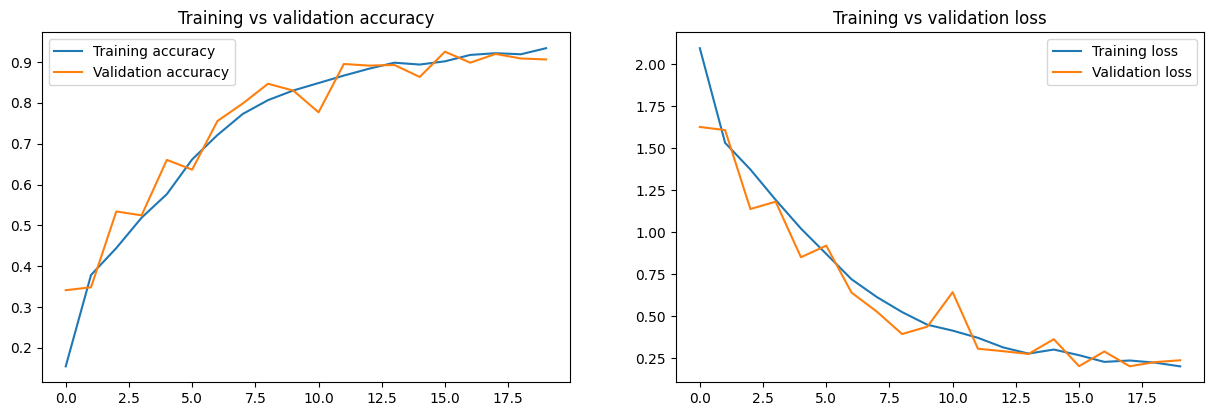

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
pred = model.predict(test)

85/85 [==============================] - 1193s 14s/step


In [ ]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [ ]:
labels = train.class_indices

In [ ]:
labels

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
labels = dict((v,k) for k, v in labels.items())

In [ ]:
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [ ]:
y_pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(x_test.label, y_pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.96      0.98       291
   Gilt-Head Bream       0.92      0.54      0.68       321
   Hourse Mackerel       0.93      0.99      0.96       301
        Red Mullet       1.00      0.99      1.00       314
     Red Sea Bream       0.67      0.98      0.80       287
          Sea Bass       0.92      0.89      0.90       293
            Shrimp       0.96      1.00      0.98       298
Striped Red Mullet       0.98      0.92      0.95       305
             Trout       0.95      0.98      0.96       290

          accuracy                           0.91      2700
         macro avg       0.93      0.92      0.91      2700
      weighted avg       0.93      0.91      0.91      2700



In [ ]:
print(confusion_matrix(x_test.label, y_pred))

[[279   0  11   0   0   1   0   0   0]
 [  0 174   4   0 116  17   0   0  10]
 [  0   0 298   0   1   2   0   0   0]
 [  0   0   0 311   0   0   0   3   0]
 [  0   0   5   0 281   0   0   0   1]
 [  0   9   1   0  15 261   0   3   4]
 [  0   0   0   0   0   0 298   0   0]
 [  0   6   2   0   0   2  13 282   0]
 [  0   0   0   0   5   1   0   0 284]]
